In [17]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from transformers import BertTokenizer, BertModel
import torch

In [19]:
path = '../input/fashion-product-images-dataset/fashion-dataset/'
dataset_path = pathlib.Path(path)
dirs_names = os.listdir(dataset_path) # list content of dataset
dirs_names

['images.csv', 'images', 'styles.csv', 'styles', 'fashion-dataset']

# **Data Collection**

In [20]:
df = pd.read_csv(path + "styles.csv", nrows=6000) # Read 6000 product and drop bad lines 
df['image'] = df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)

In [21]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [22]:
df.sample(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
420,18230,Men,Apparel,Topwear,Tshirts,White,Fall,2011,Casual,Manchester United Men Printed White Tshirt,18230.jpg
5416,8341,Boys,Apparel,Topwear,Tshirts,Green,Fall,2011,Casual,Doodle Boy's Volleyball Champion Green White K...,8341.jpg
5121,17815,Men,Footwear,Sandal,Sandals,Black,Fall,2011,Casual,Lee Cooper Men Black Sandal,17815.jpg
2934,58729,Women,Apparel,Topwear,Tshirts,Blue,Summer,2012,Casual,Puma Women Blue T-shirt,58729.jpg
545,52647,Women,Accessories,Bags,Handbags,Black,Summer,2012,Casual,Mod'acc Women Black Handbag,52647.jpg
2571,49638,Women,Apparel,Topwear,Tops,Pink,Summer,2012,Casual,Mineral Women Pink Top,49638.jpg
819,29773,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Casual,Wrangler Men Green Striped Shirt,29773.jpg
3659,4522,Men,Footwear,Shoes,Sports Shoes,Grey,Summer,2011,Sports,Puma Men's Faas Grey Shoes,4522.jpg
4904,16792,Men,Apparel,Topwear,Shirts,Yellow,Fall,2011,Casual,Highlander Men Check Yellow Shirt,16792.jpg
3825,42088,Men,Footwear,Shoes,Sports Shoes,Brown,Summer,2012,Sports,ADIDAS Men Brown Zapotec Shoes,42088.jpg


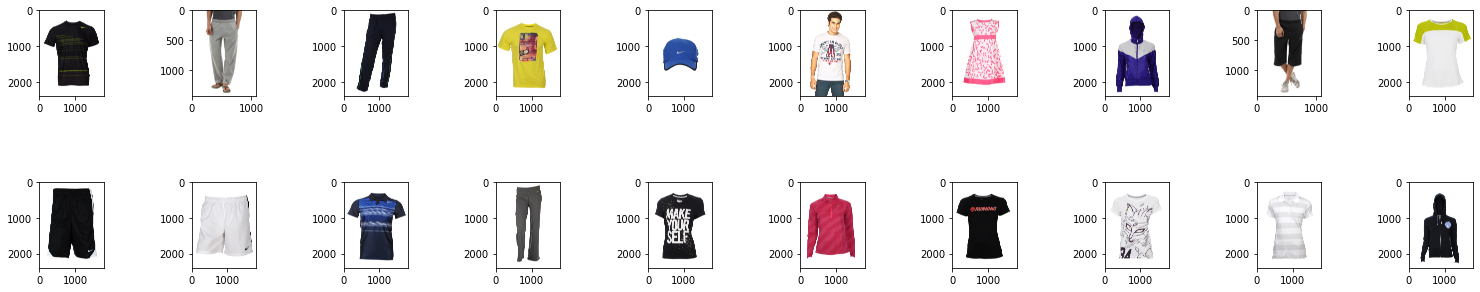

In [23]:
# Plot samples 
plt.figure(figsize=(30,30))
for i in range(10,30):
    plt.subplot(10, 10, i-10+1)
    cloth_img =  mpimg.imread(path + 'images/100' + str(i) +'.jpg') # Assign images ids
    plt.imshow(cloth_img)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

<AxesSubplot:>

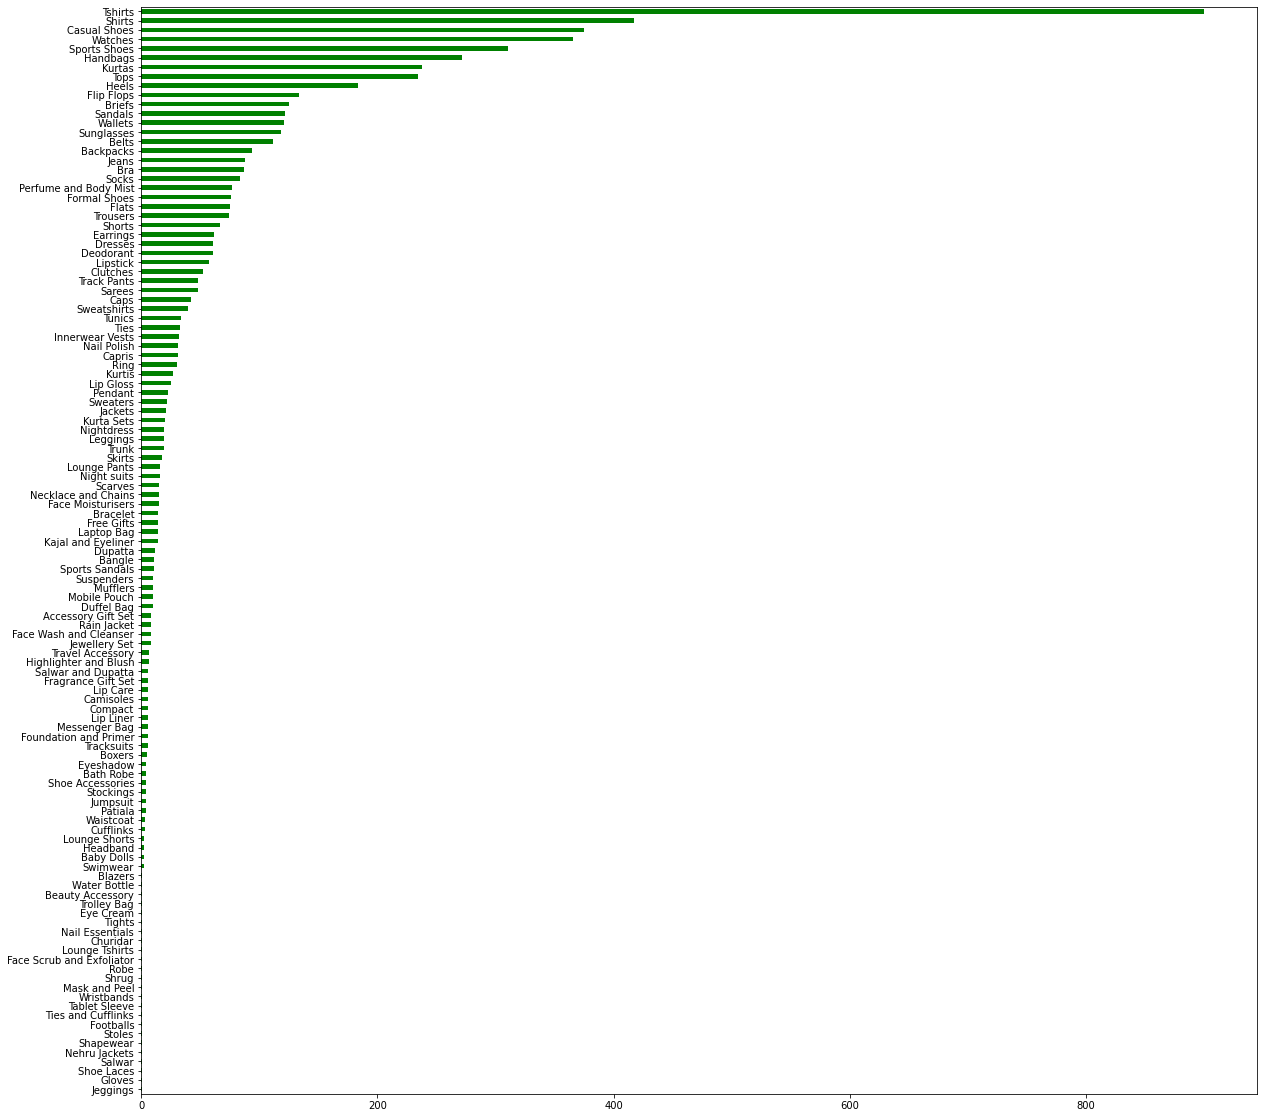

In [24]:
plt.figure(figsize=(20,20))
df.articleType.value_counts().sort_values().plot(kind='barh', color='green')

# **Data Preprocessing**

# Image Preprocessing

In [25]:
image_path = '../input/fashion-product-images-dataset/fashion-dataset/images/'

In [26]:
def preprocess_image(image_path, target_size=(100, 100)):
    try:
        # Read and resize image
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)
        
        # Normalize image
        img = img / 255.0
        
        return img
    except Exception as e:
        print(f"Error preprocessing image {image_path}: {str(e)}")
        return None

In [27]:
# Define the ImageDataGenerator with preprocessing options
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=30,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2  # Splitting the data for both train and test as 80 and 20
)

In [28]:
def data_generator(image_paths, batch_size=32):
    num_samples = len(image_paths)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_image_paths = image_paths[offset:offset+batch_size]
            images = [preprocess_image(image_path) for image_path in batch_image_paths]
            images = np.array(images)
            yield images

In [29]:
# Get a list of all image paths
all_image_paths = [os.path.join(image_path, filename) for filename in os.listdir(image_path)]

In [30]:
# Define batch size
batch_size = 32

# Create a generator
gen = data_generator(all_image_paths, batch_size=batch_size)

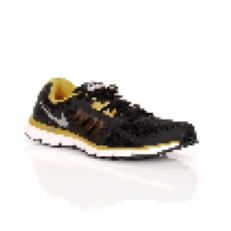

In [31]:
# Get one batch of preprocessed images
batch_images = next(gen)

# Plot the first image in the batch
plt.imshow(batch_images[0])
plt.axis('off')
plt.show()


# Text Preprocessing

In [33]:
def preprocessText(text):
    try:
        tokens = word_tokenize(str(text))  # Ensure text is converted to string
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
        return ' '.join(filtered_tokens)
    except Exception as e:
        print(f"Error preprocessing text: {e}")
        return ''  # Return empty string or handle the error appropriately

In [34]:
df['processed_text'] = df['productDisplayName'].apply(preprocessText)
# Convert text to numerical representations using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

In [35]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,processed_text
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg,Puma Men Grey T-shirt


# **Feature Extraction**

# Textual Features

In [36]:
tokenizer = BertTokenizer.from_pretrained('/kaggle/input/bert-base-uncased')
model = BertModel.from_pretrained("/kaggle/input/bert-base-uncased")

Some weights of the model checkpoint at /kaggle/input/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
# Function to extract BERT embeddings for text
def extract_bert_embeddings(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True)
    
    # Forward pass through BERT model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extract the embeddings of the [CLS] token (the first token)
    cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    
    return cls_embeddings

In [39]:
# Apply BERT embeddings extraction to the 'processed_text' column
df['bert_embeddings'] = df['processed_text'].apply(extract_bert_embeddings)

In [40]:
# Check the shape of the BERT embeddings
print(df['bert_embeddings'][0].shape)  # Example: Print the shape of BERT embeddings for the first row

(1, 768)


# Visual Features

In [41]:
img_width, img_height, chnls = 100, 100, 3

In [42]:
# Load VGG16 model with pre-trained weights from the uploaded file
vgg16_weights_path = '/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16 = VGG16(include_top=False, weights=vgg16_weights_path, input_shape=(img_width, img_height, chnls))
vgg16.trainable = False
vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
vgg16_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [43]:
def img_path(img):
    """ Take image name(id) and return the complete path of it """
    return path + 'images/' + img

def predict(model, img_name):
    """ Load and preprocess image then make prediction """
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
#     img = image.load_img(os.path.join(path, "images", img_name), target_size=(img_width, img_height))
    # img to Array
    img = image.img_to_array(img)
    # Expand Dim (1, w, h)
    img = np.expand_dims(img, axis=0)
    # Pre process Input
    img = preprocess_input(img)
    return model.predict(img)

In [44]:
def get_embeddings(df, model):
    """ Return a dataframe contains images features """
    df_copy = df
    df_embeddings = df_copy['image'].apply(lambda x: predict(vgg16_model, x).reshape(-1))
    df_embeddings = df_embeddings.apply(pd.Series)
    return df_embeddings

df_embeddings = get_embeddings(df, vgg16_model)


In [45]:
df_embeddings.to_csv("/kaggle/working/df_embeddings.csv", index=False)

In [62]:
df_embeddings['bert_embeddings'] = df['bert_embeddings']

In [63]:
df_embeddings.head(5)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,bert_embeddings
0,0.000000,0.0,0.000000,0.0,0.144590,0.000000,0.000000,0.0,0.0,0.0,...,3.153262,0.000000,0.000000,3.582393,0.093604,0.000000,0.000000,0.403044,3.082345,"[[0.044980608, -0.13994968, -0.46511805, 0.044..."
1,0.214866,0.0,0.642268,0.0,0.721050,0.000000,0.961315,0.0,0.0,0.0,...,3.489841,0.444949,1.035508,4.321324,0.276158,0.657143,1.072055,0.752606,2.018364,"[[-0.21268304, -0.035330385, -0.01353978, 0.15..."
2,1.869812,0.0,0.000000,0.0,0.445198,0.000000,0.000000,0.0,0.0,0.0,...,0.185554,0.671141,0.076806,0.000000,0.400541,0.000000,0.000000,0.968237,0.000000,"[[-0.3263574, 0.08085328, -0.15622397, -0.0220..."
3,0.067576,0.0,0.000000,0.0,0.598627,0.000000,0.206586,0.0,0.0,0.0,...,2.009502,0.382332,0.000000,1.067553,0.187985,0.000000,0.000000,0.145139,3.934349,"[[-0.058984596, -0.43512338, -0.34662127, 0.20..."
4,0.000000,0.0,0.000000,0.0,0.090579,0.164339,0.000000,0.0,0.0,0.0,...,0.341517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115651,1.671086,"[[0.057162795, -0.60067266, -0.61613953, 0.074..."


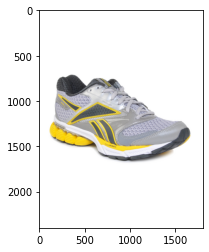

In [47]:
url="../input/fashion-product-images-dataset/fashion-dataset/images/10037.jpg"
a = plt.imread(url)
plt.imshow(a)

In [48]:
sample_image = predict(vgg16_model, '10004.jpg')
sample_image.shape

(1, 512)

In [49]:
df_sample_image = pd.DataFrame(sample_image)  
print(df_sample_image)

        0    1         2    3         4    5         6    7    8         9    \
0  0.776613  0.0  1.300606  0.0  1.737912  0.0  0.309801  0.0  0.0  0.503222   

   ...       502       503       504       505      506       507  508  \
0  ...  1.188264  0.910136  0.289093  0.953729  1.23384  0.366526  0.0   

        509       510       511  
0  1.295649  0.185353  0.069374  

[1 rows x 512 columns]


In [50]:
sample_similarity = linear_kernel(df_sample_image, df_embeddings)
print(sample_similarity)

[[291.46725 394.18408 278.95206 ... 351.35434 312.08826 322.3956 ]]


In [51]:
def get_similarity(model):
    """ Get similarity of custom image """
    sample_image = predict(vgg16_model, '10004.jpg')
    df_sample_image = pd.DataFrame(sample_image)
    sample_similarity = linear_kernel(df_sample_image, df_embeddings)
    return sample_similarity

In [52]:
def normalize_sim(similarity):
    """ Normalize similarity results """
    x_min = similarity.min(axis=1)
    x_max = similarity.max(axis=1)
    norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
    return norm

sample_similarity_norm = normalize_sim(sample_similarity)
sample_similarity_norm.shape

(1, 6000)

In [53]:
def get_recommendations(df, similarity):
    """ Return the top 5 most similar products """
    # Get the pairwsie similarity scores of all clothes with that one (index, value)
    sim_scores = list(enumerate(similarity[0]))
    
    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[0:5]
    print(sim_scores)
    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar products
    return df['image'].iloc[cloth_indices]

[(2575, 1.0), (1387, 0.999687), (4897, 0.9887497), (5508, 0.972353), (2790, 0.939924)]


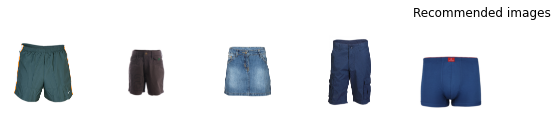

In [54]:
recommendation = get_recommendations(df, sample_similarity_norm)
recommendation_list = recommendation.to_list()
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + 'images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

# **Class for Recommendation System**

In [55]:
import numpy as np
import pandas as pd
import os 
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

class fashion_recommendations:
    """ Production class for recommendations of fashion from similarity """
    
    def __init__(self, img_path, df_embeddings, styles_path):
        self.img_path = img_path
        self.df_embeddings = df_embeddings
        self.styles_path = styles_path
    # Helper functions 
    def get_styles_df(self):
        """ Load a dataframe contains styles details and images """
        styles_df = pd.read_csv(self.styles_path, nrows=6000) # Read 6000 product and drop bad lines
        styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
        return styles_df
    
    def load_model(self):
        """ Load our model """
        # Load VGG16 model with pre-trained weights from the uploaded file
        vgg16_weights_path = '/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        vgg16 = VGG16(include_top=False, weights=vgg16_weights_path, input_shape=(img_width, img_height, chnls))
        vgg16.trainable = False
        vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
        return vgg16_model

    def predict(self, model, img_path):
        """ Load and preprocess image then make prediction """
        # Reshape
        img = image.load_img(self.img_path, target_size=(100, 100)) # đoạn này có thể chuyển thành tải ảnh theo link về
        # img to Array
        img = image.img_to_array(img)
        # Expand Dim (1, w, h)
        img = np.expand_dims(img, axis=0)
        # Pre process Input
        img = preprocess_input(img)
        return model.predict(img)
    
    def get_similarity(self):
        """ Get similarity of custom image """
        model = self.load_model()
        df_embeddings = self.df_embeddings
        sample_image = self.predict(model, self.img_path)
        df_sample_image = pd.DataFrame(sample_image)
        sample_similarity = linear_kernel(df_sample_image, df_embeddings)
        return sample_similarity
    
    def normalize_sim(self):
        """ Normalize similarity results """
        similarity = self.get_similarity()
        x_min = similarity.min(axis=1)
        x_max = similarity.max(axis=1)
        norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
        return norm
    
    def get_recommendations(self):
        """ Get recommended images """
        similarity = self.normalize_sim()
        df = self.get_styles_df()
        # Get the pairwsie similarity scores of all clothes with that one (index, value)
        sim_scores = list(enumerate(similarity[0]))

        # Sort the clothes based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 5 most similar clothes
        sim_scores = sim_scores[0:5]
        print(sim_scores)
        # Get the clothes indices
        cloth_indices = [i[0] for i in sim_scores]

        # Return the top 5 most similar products
        return df['image'].iloc[cloth_indices]
    
    def print_recommendations(self):
        """ Print the top 5 most similar products"""
        recommendation = self.get_recommendations()
        recommendation_list = recommendation.to_list()
        #recommended images
        plt.figure(figsize=(20,20))
        j=0
        for i in recommendation_list:
            plt.subplot(6, 10, j+1)
            cloth_img =  mpimg.imread("../input/fashion-product-images-dataset/fashion-dataset/" + 'images/'+ i) # Đoạn này trả về id là được
            plt.imshow(cloth_img)
            plt.axis("off")
            j+=1
        plt.title("Recommended images",loc='left')
        plt.subplots_adjust(wspace=-0.5, hspace=1)
        plt.show()
        return 

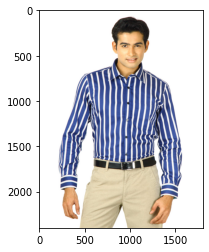

In [56]:
url = "../input/fashion-product-images-dataset/fashion-dataset/images/10188.jpg"
a = plt.imread(url)
plt.imshow(a)

[(3742, 1.0), (837, 0.9877326), (5254, 0.98694146), (4448, 0.97410136), (5817, 0.9578913)]


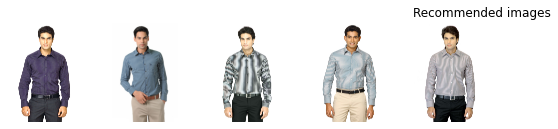

In [57]:
img_path = '../input/fashion-product-images-dataset/fashion-dataset/images/10188.jpg'
styles_path = '../input/fashion-product-images-dataset/fashion-dataset/styles.csv'
obj = fashion_recommendations(img_path, df_embeddings, styles_path)
obj.print_recommendations()

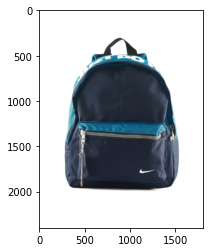

In [58]:
url = "../input/fashion-product-images-dataset/fashion-dataset/images/19318.jpg"
a = plt.imread(url)
plt.imshow(a)

[(1307, 1.0), (5545, 0.9398851), (767, 0.87453794), (5437, 0.86340576), (3913, 0.83177185)]


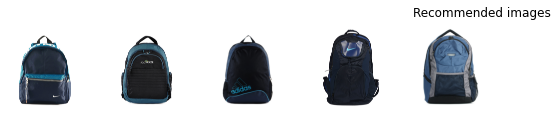

In [59]:
img_path = '../input/fashion-product-images-dataset/fashion-dataset/images/19318.jpg'
styles_path = '../input/fashion-product-images-dataset/fashion-dataset/styles.csv'
obj = fashion_recommendations(img_path, df_embeddings, styles_path)
obj.print_recommendations()

In [ ]:
model = obj.load_model()

# Lưu mô hình
model.save("/kaggle/working/AIShop_model.h5")
print("Model saved successfully!")

In [ ]:
import joblib

# Save the embeddings dataframe
joblib.dump(df_embeddings, 'df_embeddings.joblib')

# Save the model
vgg16_model.save('/kaggle/working/vgg16_model.h5')